## Section 2: Coding Questions

This section consists of coding questions. The total mark for this section is **85**. 
The task we are considering in this section is the text classification task. In this section, some code has been provided to help you get started. For each cell marked with **# Insert your code here**, these are placeholders where you **must** supply your own codes when instructed.
This section consists of 5 parts:
* Part 0: Downloading and preprocessing data. This part has been completed. No marks are allocated for this part.
* Part 1: Coding assessment on using Word2Vect to transform texts to vectors (20 marks).
* Part 2: Coding assessment on Text CNN for sequence modeling and neural embedding (10 marks).
* Part 3: Coding assessment on RNNs for sequence modeling and neural embedding (32 marks).
* Part 4: Coding assessment on Transformer for sequence modeling and neural embedding and the overall ranking (23 marks).

## <span style="color:#0b486b">Set random seeds</span>

We start with importing tensorflow and numpy and setting random seeds for TF and numpy. You can use any seeds you prefer.

In [1]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(6789)
np.random.seed(6789)

## <span style="color:#0b486b">Part 0: Download and preprocess the data</span>

<div style="text-align: right"><span style="color:red; font-weight:bold"><span></div>

The dataset we use for this assignment is a question classification dataset for which the training set consists of $5,500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR), 
- entity (ENTY), 
- description (DESC), 
- human (HUM), 
- location (LOC) and 
- numeric (NUM).

In this assignment, we will utilize a subset of this dataset, containing $2,000$ questions for training and validation. We will use 80% of those 2000 questions for trainning and the rest for validation.


Preprocessing data is a crucial initial step in any machine learning or deep learning project. The *TextDataManager* class simplifies the process by providing functionalities to download and preprocess data specifically designed for the subsequent questions in this assignment. It is highly recommended to gain a comprehensive understanding of the class's functionality by **carefully reading** the content provided in the *TextDataManager.py* file before proceeding to answer the questions in Part 1.

In [2]:
from TextDataManager import SimpleTextDataset as DataManager

print('Loading data...')
DataManager.maybe_download("data", "train_2000.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("data/", ["train_2000.label"])

Loading data...
Downloaded successfully train_2000.label

Sample questions and corresponding labels... 

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?']
['DESC', 'ENTY', 'DESC', 'ENTY', 'ABBR']


In [3]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

In [4]:
print(dm.train_str_questions)
print(dm.train_numeral_data.shape)  
print(dm.valid_numeral_data.shape)  
print(dm.train_numeral_labels.shape)

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?', 'ind what contemptible scoundrel stole the cork from my lunch ?', "gr what team did baseball 's st. louis browns become ?", 'title what is the oldest profession ?', 'def what are liver enzymes ?', 'ind name the scar-faced bounty hunter of the old west .', 'date when was ozzy osbourne born ?', 'reason why do heavier objects travel downhill faster ?', 'ind who was the pride of the yankees ?', 'ind who killed gandhi ?', 'event what is considered the costliest disaster the insurance industry has ever faced ?', 'state what sprawling u.s. state boasts the most airports ?', 'desc what did the only repealed amendment to the u.s. constitution deal with ?', 'count how many jews were executed in conce

You now have a data manager, named *dm* containing the training and validiation sets in both text and numeric forms. Your task is to play around and read this code to figure out the meanings of some important attributes that will be used in the next parts.

## <span style="color:#0b486b">Part 1: Using Word2Vect to transform texts to vectors </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 20 marks]<span></div>

In this part, you will be assessed on how to use a pretrained Word2Vect model for realizing a machine learning task. Basically, you will use this pretrained Word2Vect to transform the questions in the above dataset stored in the *data manager object dm* to numeric form for training a classifier using Logistic Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [5]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np

#### <span style="color:red">**Question 1.1**</span> 
**Write code to download the pretrained model *glove-wiki-gigaword-100*. Note that this model transforms a word in its dictionary to a $100$ dimensional vector.**

**Write code for the function *get_word_vector(word, model)* used to transform a word to a vector using the pretrained Word2Vect model *model*. Note that for a word not in the vocabulary of our *word2vect*, you need to return a vector $0$ with 100 dimensions.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div> 

In [7]:
# Install the pretrained Word2Vect model.
word2vect = api.load("glove-wiki-gigaword-100")

In [8]:
def get_word_vector(word, model):
    """
    Get the word vector for a given word from a word embedding model.
    """
    try:
        vector = model[word]                    # Attempt to retrieve the word vector from the model
    except KeyError:                            # Handle the case when the word is not in the vocabulary
        vector = np.zeros(model.vector_size)    # Create a zero vector with the same dimension as the model's vectors
    return vector

#### <span style="color:red">**Question 1.2**</span> 

**Write the code for the function `get_sentence_vector(sentence, important_score=None, model= None)`. Note that this function will transform a sentence to a 100-dimensional vector using the pretrained model *model*. In addition, the list *important_score* which has the same length as the *sentence* specifies the important scores of the words in the sentence. In your code, you first need to apply *softmax* function over *important_score* to obtain the important weight *important_weight* which forms a probability over the words of the sentence. Furthermore, the final vector of the sentence will be weighted sum of the individual vectors for words and the weights in *important_weight*.**
- $important\_weight = softmax(important\_score)$.
- $final\_vector= important\_weight[1]\times v[1] + important\_weight[2]\times v[2] + ...+ important\_weight[T]\times v[T]$ where $T$ is the length of the sentence and $v[i]$ is the vector representation of the $i-th$  word in this sentence.

**Note that if `important_score=None` is set by default, your function should return the average of all representation vectors corresponding to set `important_score=[1,1,...,1]`.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div> 

In [9]:
def get_sentence_vector(sentence, important_score = None, model = None):
    """
    Calculate a sentence vector based on word vectors and optional importance scores.
    """
    # Split the sentence into a list of words.
    words_list = sentence.split()
    # Initialise the sentence_vector as array of zeroes of length 100.
    sentence_vector = np.zeros(100)
    
    # If the important score list is not provided, set all scores to 1.
    if important_score == None:
        important_score = [1] * len(words_list)

    # Subtracting the maximum value from important_score to prevent overflow.
    max_x = np.max(important_score)
    exp_x = np.exp(important_score - max_x)
    
    # Compute the softmax weights for the important scores.
    important_weight = exp_x / exp_x.sum(axis = 0)
    
    # Loop through the words list, adding the weighted word vector to the final vector
    for i in range(len(words_list)):
        word_vector = get_word_vector(words_list[i], model)     # Get its word vector
        sentence_vector += important_weight[i] * word_vector    # Add its weighted word vector to sentence_vector
    
    return sentence_vector      # Return the sentence vector to caller.

#### <span style="color:red">**Question 1.3**</span> 

**Write code to transform questions in *dm.train_str_questions* and *dm.valid_str_questions* to feature vectors. Note that after running the following cells, you must have $X\_train$ and $X\_valid$ which are two numpy arrays of the feature vectors and $y\_train$ and $y\_valid$ which are two arrays of numeric labels (Hint: *dm.train_numeral_labels* and *dm.valid_numeral_labels*). You can add more lines to the following cells if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[4 marks]</span></div> 

In [10]:
def train(dataset):
    """
    Transform quuestions to feature vectors.
    """
    # Initialise an empty list to store the feature vectors for questions.
    result = []

    # Loop through each question in the dataset.
    for question in dataset:
        # Get the feature vector for the current question using the get_sentence_vector function and the word2vect model.
        feature_vector = get_sentence_vector(question, model = word2vect)

        # Append the feature vector to the list result.
        result.append(feature_vector)

    return result  # Return the list of feature word_word_vectors for questions.

print("Transform training set to feature vectors...")
# Call the train function to obtain the training feature vectors. Use the training dataset.
X_train = train(dm.train_str_questions)
# Assign the training labels.
y_train = dm.train_numeral_labels

Transform training set to feature vectors...


In [11]:
print("Transform validation set to feature vectors...")
# Call the train function to obtain the validation feature vectors. Use the validation dataset.
X_valid = train(dm.valid_str_questions)
# Assign the validation labels.
y_valid = dm.valid_numeral_labels

Transform validation set to feature vectors...


#### <span style="color:red">**Question 1.4**</span> 

**It is now to use *MinMaxScaler(feature_range=(-1,1))* in scikit-learn to scale both training and validation sets to the range $(-1,1)$.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div> 

In [12]:
# Create a MinMaxScaler with a specified feature range (-1, 1).
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler to the training data and then transform the data.
scaler.fit(X_train)                     # Fit the scaler on the training data
X_train = scaler.transform(X_train)     # Transform the training data

# Fit the scaler to the validation data and then transform the data.
scaler.fit(X_valid)                     # Fit the scaler on the validation data
X_valid = scaler.transform(X_valid)     # Transform the validation data


#### <span style="color:red">**Question 1.5**</span>
**Train a Logistic Regression model on the training set and then evaluate on the validation set.**
<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [13]:
from sklearn.linear_model import LogisticRegression

# Create a LogisticRegression model.
model = LogisticRegression()

# Fit the model on the training data.
model.fit(X_train, y_train)


LogisticRegression()

In [14]:
y_pred = model.predict(X_valid)
print("Validation Accuracy: {0}".format(accuracy_score(y_valid, y_pred)))

Validation Accuracy: 0.7625


### **Embedding visualization**

**As you know, the embedding matrix is a collection of embedding vectors, each is for one word. In this part, you will base on the cosine similarity of the embedding vectors for the words to find the top-k most relevant words for a given word.**

**Good embeddings should have words close in meaning near each other by some similarity metrics. The similarity metric we'll use is the `consine` similarity, which is defined for two vector $\mathbf{u}$ and $\mathbf{v}$ as $\cos(\mathbf{u}, \mathbf{v})=\frac{\mathbf{u} \cdot \mathbf{v}}{\left\Vert{\mathbf{u}}\right\Vert\left\Vert{\mathbf{v}}\right\Vert}$ where $\cdot$ means dot product and $\left\Vert\cdot\right\Vert$ means the $L^2$ norm.**

In [15]:
def cosine_similarity(u,v):
    return np.dot(u,v)/(np.linalg.norm(u)*np.linalg.norm(v))

#### <span style="color:red">**Question 1.6** </span> 

**Write code for the `function find_most_similar(word=None, k=5, model=None)` which returns a list of the top-`k` most similar words (in descending order) for a given word. This similarity is based on the cosine similarity of embedding vectors obtained from the pretrained model `glove-wiki-gigaword-100` (see Question 1.1). The parameter `include_cur_word` specifies whether the given word should be included in the returned output or not. This means that if `include_cur_word=True`, the function will return `k+1` words.** 

<div style="text-align: right"><span style="color:red">[3 marks]</span></div>

In [16]:
def find_most_similar(word=None, k=5, model=None, include_cur_word=False):
    """
    This function calculates the most similar words to a provided word within the word embedding model based on cosine similarity 
    between word vectors. It returns a list of the most similar words and a list of cosine similarity scores.
    """
    try:
        # Get the word vector for the provided word using the given model.
        word_vector = get_word_vector(word, model)
        
        # Create a dictionary to store similarities between the provided word and all other words in the model's vocabulary.
        similarities = {}
        for another_word in model.key_to_index:
            # Calculate cosine similarity between the word vectors.
            similarities[another_word] = cosine_similarity(word_vector, get_word_vector(another_word, model))
            
        # Sort the similarities in descending order to find the most similar words.
        sorted_similarities = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
        
        # Extract the most similar words and their cosine similarities.
        similar_words = []
        similar_cos_sim = []
        for i in range(k + 1):
            similar_words.append(sorted_similarities[i][0])
            similar_cos_sim.append(sorted_similarities[i][1])

        # Remove the current word from the list of similar words and consine similarities if word is not to be included.
        if not include_cur_word and word in similar_words:
            similar_words.pop(similar_words.index(word))
            similar_cos_sim.pop(similar_words.index(word))
            
        # Return a list containing the most similar words and their cosine similarities.
        return [similar_words, similar_cos_sim]
    
    except KeyError:  # Handle the case when the provided word is not in the model's vocabulary.
        print("Word is not in the dictionary!")

Here is the example of the above function. You can check your implementation using the provided `result`. As you can observe, the `result` makes sense which demonstrates that the embedding matrix is meaningful.

In [17]:
result = ['computer','computers','software','technology','pc','hardware','internet','desktop','electronic','systems','computing']
output = find_most_similar(word='computer', k=10, model=word2vect, include_cur_word=True)[0]
if output == result:
    print("Your implementation is correct.")
else:
    print("Your implementation is not correct.")

Your implementation is correct.


#### <span style="color:red">**Question 1.7** </span> 
**Implement the `plot2D_with_groups(word_list, model, k=10)` function to visualize groups of similar words in 2D space. The `word_list` parameter is a list of words, and for each word in the `word_list`, find its top-`k` most similar words (which forms a group) using the `find_most_similar` function. Use tSNE to project embedding vectors into 2D space and plot groups with different colors. You can use the colormaps from `matplotlib`, i.e., `cmap = plt.get_cmap('brg')`.**

**The figure bellow is the output obtained by running `plot2D_with_groups` using the input `word_list=['an', 'introduction', 'to', 'deep', 'learning']`. Note that the words within the `word_list` are also visualized (in black) as shown in the figure.**

<img src="./images/2Dtsne.png" align="center" width=600/>

**As you can observe, words within each group tend to be closer to each other, while words from different groups are more distant.**

<div style="text-align: right"><span style="color:red">[5 marks]</span></div>

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Create a TSNE object with specified parameters.
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)

def plot2D_with_groups(word_list=None, k=10, model=None):
    """
    This function takes a list of words, retrieves their similar words based on a word embedding model, and then visualizes them in a 2D space 
    using t-SNE. Words within the same group share the same color.
    """
    try:
        words = []         # List to store all words to be plotted.
        word_vectors = []  # List to store the corresponding word vectors.

        # For each word in the provided word list, find similar words by calling the find_most_similar method.
        for word in word_list:
            similar_words, _ = find_most_similar(word, k, model, include_cur_word=True)

            # Append similar words and their vectors to their respective lists.
            for similar_word in similar_words:
                words.append(similar_word)
                word_vectors.append(get_word_vector(similar_word, model))

        # Convert word_vectors to a NumPy array.
        word_vectors = np.array(word_vectors)

        # Apply t-SNE to reduce the dimensionality and obtain 2D vectors.
        reduced_vectors = tsne.fit_transform(word_vectors)

        # Create a 2D scatter plot of figure size 8 x 8.
        plt.figure(figsize=(8, 8))

        i = 0
        while i < len(reduced_vectors):
            # Scatter plot points with different colors for each group.
            plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1],
                        color = plt.get_cmap("brg", len(word_list))(i // (k + 1)))

            # Annotate points with their words.
            # Only selected words are black.
            if words[i] in word_list:
                plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], words[i], fontsize = 9, color = "black")
            # Rest will be their point colour.
            else:
                plt.text(reduced_vectors[i, 0], reduced_vectors[i, 1], words[i], fontsize = 9,
                         color = plt.get_cmap("brg", len(word_list))(i // (k + 1)))

            i += 1

        # Show the plot.
        plt.show()

    except KeyError:  # Handle the case when the provided word is not in the model's vocabulary.
        print("Word is not in the dictionary!")

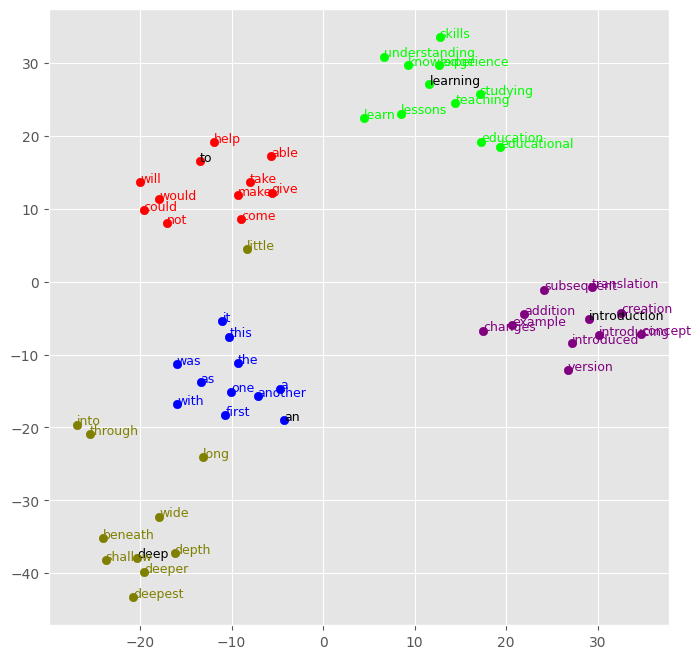

In [19]:
word_list = ['an', 'introduction', 'to', 'deep', 'learning']
plot2D_with_groups(word_list=word_list, k=10, model=word2vect)

## <span style="color:#0b486b">Part 2: Text CNN for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 marks]<span></div>

#### <span style="color:red">**Question 2.1**</span> 

**In what follows, you are required to complete the code for Text CNN for sentence classification. The paper of Text CNN can be found at this [link](https://www.aclweb.org/anthology/D14-1181.pdf). Here is the description of the Text CNN that you need to construct.**
- There are three attributes (properties or instance variables): *embed_size, state_size, data_manager*.
  - `embed_size`: the dimension of the vector space for which the words are embedded to using the embedding matrix.
  - `state_size`: the number of filters used in *Conv1D* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)).
  - `data_manager`: the data manager to store information of the dataset.
- The detail of the computational process is as follows:
  - Given input $x$, we embed $x$ using the embedding matrix to obtain an $3D$ tensor $[batch\_size \times maxlen \times embed\_size]$ as $h$.
  - We feed $h$ to three *Conv1D* layers, each of which has $state\_size$ filters, padding=same, activation= relu, and $kernel\_size= 3, 5, 7$ respectively to obtain $h1, h2, h3$. Note that each $h1, h2, h3$ is a 3D tensor with the shape $[batch\_size \times output\_size \times state\_size]$.
  - We then apply *GlobalMaxPool1D()* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D)) over $h1, h2, h3$ to obtain 2D tensors stored in $h1, h2, h3$ again.
  - We then concatenate three 2D tensors $h1, h2, h3$ to obtain $h$. Note that you need to specify the axis to concatenate.
  - We finally build up one dense layer on the top of $h$ for classification.
  
  <div style="text-align: right"><span style="color:red">[8 marks]</span></div>
  

In [20]:
class TextCNN:
    def __init__(self, embed_size= 128, state_size=16, data_manager=None):
        self.data_manager = data_manager
        self.embed_size = embed_size
        self.state_size = state_size
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.data_manager.vocab_size +1, self.embed_size, mask_zero=True)(x)
        h1 = tf.keras.layers.Conv1D(self.state_size, 3, activation = "relu", padding = "same")(h)
        h2 = tf.keras.layers.Conv1D(self.state_size, 5, activation = "relu", padding = "same")(h)
        h3 = tf.keras.layers.Conv1D(self.state_size, 7, activation = "relu", padding = "same")(h)
        h1 = tf.keras.layers.GlobalMaxPool1D()(h1)
        h2 = tf.keras.layers.GlobalMaxPool1D()(h2)
        h3 = tf.keras.layers.GlobalMaxPool1D()(h3)
        h = tf.keras.layers.Concatenate(-1)([h1, h2, h3])
        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h) 
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 2.2**</span> 
**Here is the code to test TextCNN above. You can observe that TextCNN outperforms the traditional approach Word2Vect with Logistic Regression for this task. The reason is that TextCNN enables us to automatically learn the feature that fits to the task. This makes deep learning different from hand-crafted feature approaches. Complete the code to test the model. Note that when compiling the model, you can use the Adam optimizer.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [ ]:
# Create a TextCNN model with the specified data manager.
text_cnn = TextCNN(data_manager=dm)

# Build the model architecture.
text_cnn.build()

# Compile the model with the specified optimiser, loss function, and metrics.
text_cnn.compile_model("adam", "sparse_categorical_crossentropy", ["accuracy"])

# Train the model using the training dataset and validate it using the validation dataset.
# The model is trained for 20 epochs with a batch size of 32.
his = text_cnn.fit(dm.tf_train_set.batch(32), epochs = 20, validation_data = dm.tf_valid_set.batch(32))


Epoch 1/20
50/50 [==============================] - 3s 36ms/step - loss: 1.5344 - accuracy: 0.4750 - val_loss: 1.1790 - val_accuracy: 0.7900
Epoch 2/20
50/50 [==============================] - 2s 31ms/step - loss: 0.7049 - accuracy: 0.8869 - val_loss: 0.3767 - val_accuracy: 0.9450
Epoch 3/20
50/50 [==============================] - 1s 27ms/step - loss: 0.2180 - accuracy: 0.9494 - val_loss: 0.1807 - val_accuracy: 0.9550
Epoch 4/20
50/50 [==============================] - 1s 28ms/step - loss: 0.0984 - accuracy: 0.9819 - val_loss: 0.1259 - val_accuracy: 0.9650
Epoch 5/20
50/50 [==============================] - 2s 33ms/step - loss: 0.0525 - accuracy: 0.9956 - val_loss: 0.1025 - val_accuracy: 0.9675
Epoch 6/20
50/50 [==============================] - 2s 32ms/step - loss: 0.0301 - accuracy: 0.9994 - val_loss: 0.0906 - val_accuracy: 0.9650
Epoch 7/20
50/50 [==============================] - 1s 29ms/step - loss: 0.0185 - accuracy: 0.9994 - val_loss: 0.0807 - val_accuracy: 0.9675
Epoch 8/20
50

In [ ]:
# Evaluate the model.
text_cnn.evaluate(dm.tf_valid_set.batch(32))

 1/13 [=>............................] - ETA: 0s - loss: 0.0475 - accuracy: 0.9688

13/13 [==============================] - 0s 8ms/step - loss: 0.0661 - accuracy: 0.9700


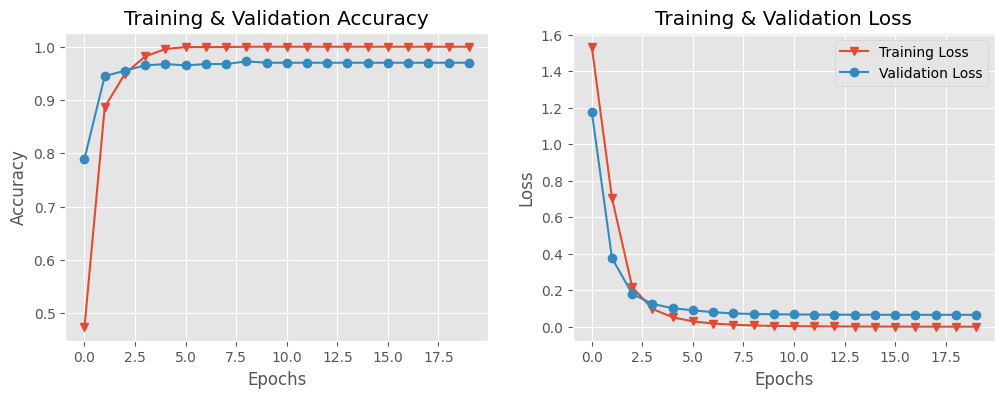

In [ ]:
# Create a figure with a specific size (12 units wide and 4 units tall).
plt.figure(figsize = (12, 4))
# Create a subplot with 1 row, 2 columns, and select the 1st subplot.
plt.subplot(1, 2, 1)

# Plot the training accuracy over epochs and label it as "Training Accuracy".
plt.plot(his.history["accuracy"], label = "Training Accuracy", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Accuracy".
plt.plot(his.history["val_accuracy"], label = "Validation Accuracy", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Set the title of the plot as "Training & Validation Accuracy".
plt.title("Training & Validation Accuracy")

# Select the 2nd subplot.
plt.subplot(1, 2, 2)

# Plot the training loss over epochs and label it as "Training Loss".
plt.plot(his.history["loss"], label = "Training Loss", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Loss".
plt.plot(his.history["val_loss"], label = "Validation Loss", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Set the title of the plot as "Training & Validation  Loss".
plt.title("Training & Validation Loss")

# Display a legend indicating which line represents which data.
plt.legend()

# Display the graph.
plt.show()

## <span style="color:#0b486b">Part 3: RNN-based models for sequence modeling and neural embedding</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 32 marks]<span></div>

### <span style="color:#0b486b">3.1. RNNs with different cell types</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 12 marks]<span></div>

#### <span style="color:red">**Question 3.1.1**</span> 
**In this part, you need to construct a vanilla RNN to learn from the dataset of interest. Basically, you are required to construct the class RNN with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can take one of the three values, i.e., `simple_rnn`, `gru`, or `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Note that when declaring an embedding layer for the network, you need to set *mask_zero=True* so that the padding zeros in the sentences will be masked and ignored. This helps to have variable length RNNs. For more detail, you can refer to this [link](https://www.tensorflow.org/guide/keras/masking_and_padding).**

<div style="text-align: right"><span style="color:red">[7 marks]</span></div>

In [21]:
class BaseRNN:
    def __init__(self, cell_type='gru', embed_size=128, state_sizes=[128, 64], data_manager=None):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size + 1 
        
    # return the corresponding memory cell
    @staticmethod
    def get_layer(cell_type='gru', state_size=128, return_sequences=False, activation='tanh'):
        if cell_type == "simple-rnn":
            return tf.keras.layers.SimpleRNN(state_size, activation, return_sequences = return_sequences)
        elif cell_type == "gru":
            return tf.keras.layers.GRU(state_size, activation, return_sequences = return_sequences)
        elif cell_type == "lstm":
            return tf.keras.layers.LSTM(state_size, activation, return_sequences = return_sequences)
    
    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero = True)(x)
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            # Extract the cell type from self.cell_type.
            cell_type = self.cell_type
            # Extract the state size for the current layer from the list self.state_sizes.
            state_size = self.state_sizes[i]
            # Determine whether the current layer should return sequences.
            return_sequences = i != (num_layers - 1)
            # Apply a layer of the specified parameters.
            h = self.get_layer(cell_type, state_size, return_sequences = return_sequences)(h)
        h = tf.keras.layers.Dense(dm.num_classes, "softmax")(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)
   
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)       


#### <span style="color:red">**Question 3.1.2**</span> 
**Run with simple RNN ('simple_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 mark]</span></div>

In [ ]:
base_rnn = BaseRNN("simple_rnn", 128, [64, 128], dm) 
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 5s 113ms/step - loss: 0.7851 - accuracy: 0.7312 - val_loss: 0.2236 - val_accuracy: 0.9350
Epoch 2/20
25/25 [==============================] - 2s 94ms/step - loss: 0.1599 - accuracy: 0.9544 - val_loss: 0.3281 - val_accuracy: 0.9000
Epoch 3/20
25/25 [==============================] - 2s 95ms/step - loss: 0.1083 - accuracy: 0.9681 - val_loss: 0.1250 - val_accuracy: 0.9600
Epoch 4/20
25/25 [==============================] - 3s 104ms/step - loss: 0.0282 - accuracy: 0.9956 - val_loss: 0.1673 - val_accuracy: 0.9475
Epoch 5/20
25/25 [==============================] - 3s 102ms/step - loss: 0.0312 - accuracy: 0.9925 - val_loss: 0.1084 - val_accuracy: 0.9625
Epoch 6/20
25/25 [==============================] - 3s 103ms/step - loss: 0.0090 - accuracy: 0.9981 - val_loss: 0.1231 - val_accuracy: 0.9625
Epoch 7/20
25/25 [==============================] - 3s 111ms/step - loss: 0.0468 - accuracy: 0.9881 - val_loss: 0.1723 - val_accuracy: 0.9475
Epoch 8/

#### <span style="color:red">**Question 3.1.3**</span> 
**Run with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 mark]</span></div>

In [ ]:
base_rnn = BaseRNN("gru", 128, [64, 128], dm)
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 14s 329ms/step - loss: 1.6785 - accuracy: 0.2556 - val_loss: 1.5943 - val_accuracy: 0.3100
Epoch 2/20
25/25 [==============================] - 6s 240ms/step - loss: 1.2778 - accuracy: 0.4688 - val_loss: 0.8921 - val_accuracy: 0.6375
Epoch 3/20
25/25 [==============================] - 6s 233ms/step - loss: 0.5504 - accuracy: 0.8125 - val_loss: 0.3316 - val_accuracy: 0.9000
Epoch 4/20
25/25 [==============================] - 6s 229ms/step - loss: 0.1841 - accuracy: 0.9550 - val_loss: 0.2745 - val_accuracy: 0.9125
Epoch 5/20
25/25 [==============================] - 6s 239ms/step - loss: 0.0770 - accuracy: 0.9756 - val_loss: 0.2086 - val_accuracy: 0.9200
Epoch 6/20
25/25 [==============================] - 6s 226ms/step - loss: 0.0318 - accuracy: 0.9925 - val_loss: 0.1512 - val_accuracy: 0.9575
Epoch 7/20
25/25 [==============================] - 6s 239ms/step - loss: 0.0223 - accuracy: 0.9937 - val_loss: 0.1408 - val_accuracy: 0.9625
Epoch

#### <span style="color:red">**Question 3.1.4**</span> 
**Run with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 mark]</span></div>

In [ ]:
base_rnn = BaseRNN("lstm", 128, [64, 128], dm)
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 18s 395ms/step - loss: 1.6821 - accuracy: 0.2450 - val_loss: 1.5674 - val_accuracy: 0.2850
Epoch 2/20
25/25 [==============================] - 7s 278ms/step - loss: 1.0543 - accuracy: 0.6394 - val_loss: 0.5521 - val_accuracy: 0.8750
Epoch 3/20
25/25 [==============================] - 7s 295ms/step - loss: 0.3404 - accuracy: 0.9200 - val_loss: 0.2358 - val_accuracy: 0.9400
Epoch 4/20
25/25 [==============================] - 7s 284ms/step - loss: 0.1779 - accuracy: 0.9531 - val_loss: 0.1966 - val_accuracy: 0.9350
Epoch 5/20
25/25 [==============================] - 7s 282ms/step - loss: 0.0903 - accuracy: 0.9737 - val_loss: 0.2232 - val_accuracy: 0.9375
Epoch 6/20
25/25 [==============================] - 8s 306ms/step - loss: 0.0531 - accuracy: 0.9887 - val_loss: 0.1713 - val_accuracy: 0.9500
Epoch 7/20
25/25 [==============================] - 8s 307ms/step - loss: 0.0468 - accuracy: 0.9869 - val_loss: 0.1453 - val_accuracy: 0.9575
Epoch

#### <span style="color:red">**Question 3.1.5**</span> 
**Write code to conduct experiments to compare the accuracies of RNNs with the three different cell types using 2 different lists of `state_sizes` (while the other hyperparameters are fixed). Specifically, for each `state_sizes = [...]`, you should report the accuracies of RNNs with simple RNN ('simple_rnn') cell, GRU ('gru') cell, and LSTM ('lstm') cell. Give your comments on the results.**
<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

### State Size: [32, 64]

#### Simple RNN

In [ ]:
# Build Simple RNN model with batch size [32, 64].
base_rnn = BaseRNN("simple_rnn", 128, [32, 64], dm) 
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_his = base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 6s 126ms/step - loss: 1.1539 - accuracy: 0.5738 - val_loss: 0.5653 - val_accuracy: 0.8000
Epoch 2/20
25/25 [==============================] - 3s 118ms/step - loss: 0.3163 - accuracy: 0.9375 - val_loss: 0.2807 - val_accuracy: 0.9325
Epoch 3/20
25/25 [==============================] - 3s 112ms/step - loss: 0.1215 - accuracy: 0.9762 - val_loss: 0.4653 - val_accuracy: 0.8650
Epoch 4/20
25/25 [==============================] - 1s 42ms/step - loss: 0.0747 - accuracy: 0.9800 - val_loss: 0.1542 - val_accuracy: 0.9500
Epoch 5/20
25/25 [==============================] - 1s 41ms/step - loss: 0.0410 - accuracy: 0.9931 - val_loss: 0.1367 - val_accuracy: 0.9525
Epoch 6/20
25/25 [==============================] - 1s 41ms/step - loss: 0.0235 - accuracy: 0.9956 - val_loss: 0.1406 - val_accuracy: 0.9475
Epoch 7/20
25/25 [==============================] - 1s 41ms/step - loss: 0.0207 - accuracy: 0.9962 - val_loss: 0.1416 - val_accuracy: 0.9525
Epoch 8/20

In [ ]:
# Evaluate the model.
base_rnn.evaluate(dm.tf_valid_set.batch(64))

7/7 [==============================] - 0s 13ms/step - loss: 0.1681 - accuracy: 0.9500


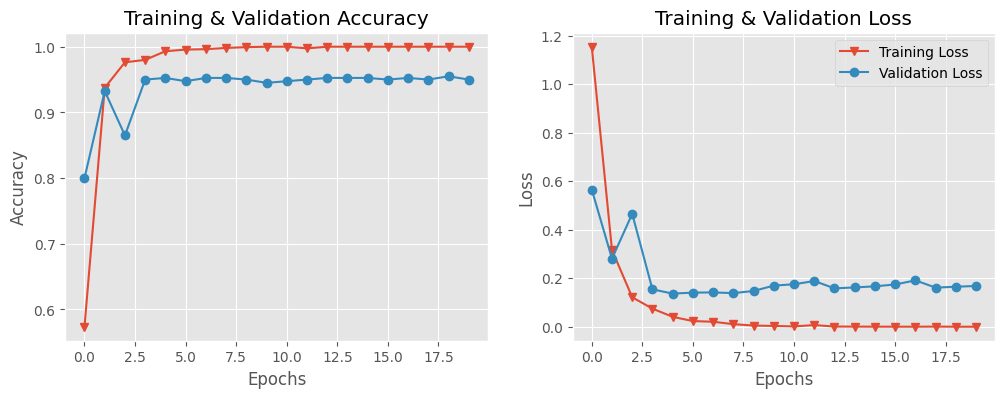

In [ ]:
# Create a figure with a specific size (12 units wide and 4 units tall).
plt.figure(figsize = (12, 4))
# Create a subplot with 1 row, 2 columns, and select the 1st subplot.
plt.subplot(1, 2, 1)

# Plot the training accuracy over epochs and label it as "Training Accuracy".
plt.plot(rnn_his.history["accuracy"], label = "Training Accuracy", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Accuracy".
plt.plot(rnn_his.history["val_accuracy"], label = "Validation Accuracy", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Set the title of the plot as "Training & Validation Accuracy".
plt.title("Training & Validation Accuracy")

# Select the 2nd subplot.
plt.subplot(1, 2, 2)

# Plot the training loss over epochs and label it as "Training Loss".
plt.plot(rnn_his.history["loss"], label = "Training Loss", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Loss".
plt.plot(rnn_his.history["val_loss"], label = "Validation Loss", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Set the title of the plot as "Training & Validation  Loss".
plt.title("Training & Validation Loss")

# Display a legend indicating which line represents which data.
plt.legend()

# Display the graph.
plt.show()

#### GRU

In [ ]:
# Build GRU model with batch size [32, 64].
base_rnn = BaseRNN("gru", 128, [32, 64], dm) 
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_his = base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 7s 143ms/step - loss: 1.6986 - accuracy: 0.2625 - val_loss: 1.6214 - val_accuracy: 0.3150
Epoch 2/20
25/25 [==============================] - 2s 81ms/step - loss: 1.5224 - accuracy: 0.3938 - val_loss: 1.3166 - val_accuracy: 0.5050
Epoch 3/20
25/25 [==============================] - 2s 78ms/step - loss: 0.8836 - accuracy: 0.6637 - val_loss: 0.6448 - val_accuracy: 0.7575
Epoch 4/20
25/25 [==============================] - 2s 86ms/step - loss: 0.3619 - accuracy: 0.9025 - val_loss: 0.2945 - val_accuracy: 0.9275
Epoch 5/20
25/25 [==============================] - 2s 80ms/step - loss: 0.1487 - accuracy: 0.9625 - val_loss: 0.2325 - val_accuracy: 0.9375
Epoch 6/20
25/25 [==============================] - 2s 80ms/step - loss: 0.0882 - accuracy: 0.9756 - val_loss: 0.2191 - val_accuracy: 0.9375
Epoch 7/20
25/25 [==============================] - 2s 71ms/step - loss: 0.0543 - accuracy: 0.9837 - val_loss: 0.2131 - val_accuracy: 0.9475
Epoch 8/20
2

In [ ]:
# Evaluate the model.
base_rnn.evaluate(dm.tf_valid_set.batch(64))

7/7 [==============================] - 0s 19ms/step - loss: 0.2892 - accuracy: 0.9575


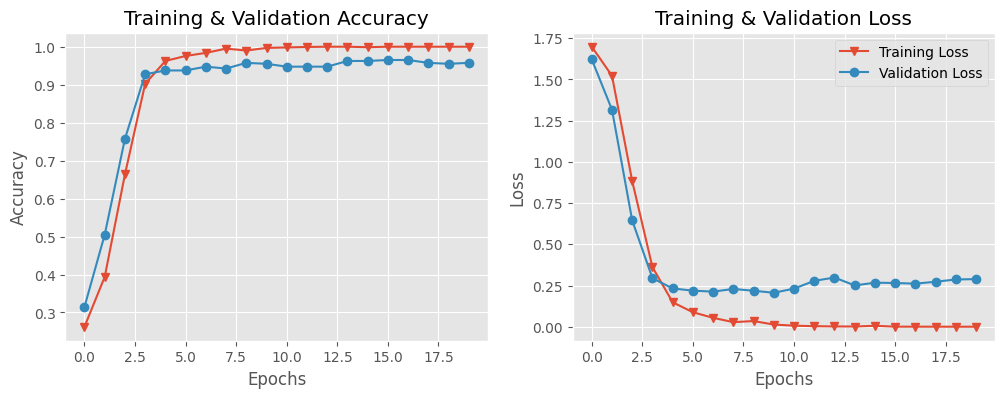

In [ ]:
# Create a figure with a specific size (12 units wide and 4 units tall).
plt.figure(figsize = (12, 4))
# Create a subplot with 1 row, 2 columns, and select the 1st subplot.
plt.subplot(1, 2, 1)

# Plot the training accuracy over epochs and label it as "Training Accuracy".
plt.plot(gru_his.history["accuracy"], label = "Training Accuracy", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Accuracy".
plt.plot(gru_his.history["val_accuracy"], label = "Validation Accuracy", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Set the title of the plot as "Training & Validation Accuracy".
plt.title("Training & Validation Accuracy")

# Select the 2nd subplot.
plt.subplot(1, 2, 2)

# Plot the training loss over epochs and label it as "Training Loss".
plt.plot(gru_his.history["loss"], label = "Training Loss", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Loss".
plt.plot(gru_his.history["val_loss"], label = "Validation Loss", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Set the title of the plot as "Training & Validation  Loss".
plt.title("Training & Validation Loss")

# Display a legend indicating which line represents which data.
plt.legend()

# Display the graph.
plt.show()

#### LSTM

In [ ]:
# Build LTSM model with batch size [32, 64].
base_rnn = BaseRNN("lstm", 128, [32, 64], dm) 
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_his = base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 9s 194ms/step - loss: 1.7063 - accuracy: 0.2594 - val_loss: 1.6017 - val_accuracy: 0.2825
Epoch 2/20
25/25 [==============================] - 3s 136ms/step - loss: 1.3268 - accuracy: 0.4963 - val_loss: 0.9854 - val_accuracy: 0.6275
Epoch 3/20
25/25 [==============================] - 3s 133ms/step - loss: 0.7486 - accuracy: 0.7731 - val_loss: 0.5241 - val_accuracy: 0.8575
Epoch 4/20
25/25 [==============================] - 3s 138ms/step - loss: 0.3414 - accuracy: 0.9187 - val_loss: 0.3110 - val_accuracy: 0.9200
Epoch 5/20
25/25 [==============================] - 3s 136ms/step - loss: 0.1992 - accuracy: 0.9513 - val_loss: 0.2378 - val_accuracy: 0.9350
Epoch 6/20
25/25 [==============================] - 4s 140ms/step - loss: 0.1098 - accuracy: 0.9769 - val_loss: 0.2132 - val_accuracy: 0.9400
Epoch 7/20
25/25 [==============================] - 3s 139ms/step - loss: 0.0824 - accuracy: 0.9825 - val_loss: 0.1873 - val_accuracy: 0.9500
Epoch 

In [ ]:
# Evaluate the model.
base_rnn.evaluate(dm.tf_valid_set.batch(64))

7/7 [==============================] - 0s 38ms/step - loss: 0.2689 - accuracy: 0.9475


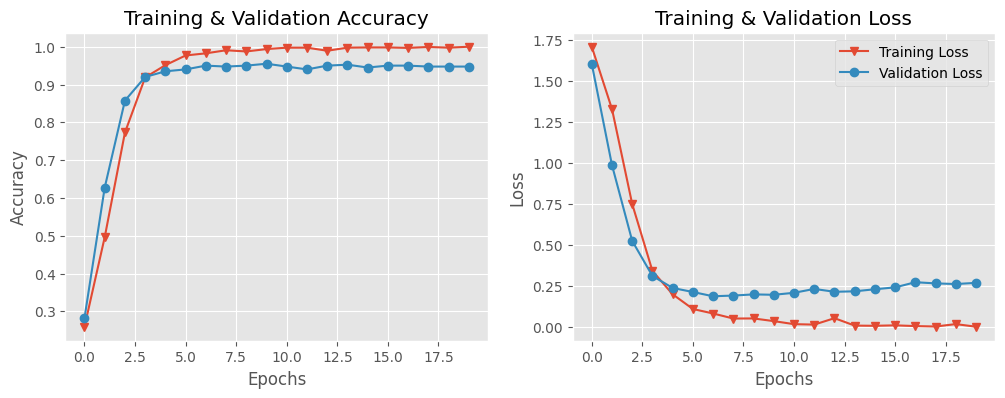

In [ ]:
# Create a figure with a specific size (12 units wide and 4 units tall).
plt.figure(figsize = (12, 4))
# Create a subplot with 1 row, 2 columns, and select the 1st subplot.
plt.subplot(1, 2, 1)

# Plot the training accuracy over epochs and label it as "Training Accuracy".
plt.plot(lstm_his.history["accuracy"], label = "Training Accuracy", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Accuracy".
plt.plot(lstm_his.history["val_accuracy"], label = "Validation Accuracy", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Set the title of the plot as "Training & Validation Accuracy".
plt.title("Training & Validation Accuracy")

# Select the 2nd subplot.
plt.subplot(1, 2, 2)

# Plot the training loss over epochs and label it as "Training Loss".
plt.plot(lstm_his.history["loss"], label = "Training Loss", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Loss".
plt.plot(lstm_his.history["val_loss"], label = "Validation Loss", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Set the title of the plot as "Training & Validation  Loss".
plt.title("Training & Validation Loss")

# Display a legend indicating which line represents which data.
plt.legend()

# Display the graph.
plt.show()

### State Size: [64, 128]

#### Simple RNN

In [ ]:
# Build Simple RNN model with batch size [64, 128].
base_rnn = BaseRNN("simple_rnn", 128, [64, 128], dm) 
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_his = base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 4s 95ms/step - loss: 0.9676 - accuracy: 0.6819 - val_loss: 0.3202 - val_accuracy: 0.9150
Epoch 2/20
25/25 [==============================] - 2s 73ms/step - loss: 0.1977 - accuracy: 0.9513 - val_loss: 0.2135 - val_accuracy: 0.9300
Epoch 3/20
25/25 [==============================] - 2s 79ms/step - loss: 0.0709 - accuracy: 0.9756 - val_loss: 0.2060 - val_accuracy: 0.9350
Epoch 4/20
25/25 [==============================] - 2s 80ms/step - loss: 0.0498 - accuracy: 0.9856 - val_loss: 0.1415 - val_accuracy: 0.9625
Epoch 5/20
25/25 [==============================] - 2s 64ms/step - loss: 0.0188 - accuracy: 0.9956 - val_loss: 0.1121 - val_accuracy: 0.9575
Epoch 6/20
25/25 [==============================] - 2s 63ms/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 0.1185 - val_accuracy: 0.9575
Epoch 7/20
25/25 [==============================] - 2s 64ms/step - loss: 0.0244 - accuracy: 0.9919 - val_loss: 0.1484 - val_accuracy: 0.9625
Epoch 8/20
25

In [ ]:
# Evaluate the model.
base_rnn.evaluate(dm.tf_valid_set.batch(64))

7/7 [==============================] - 1s 68ms/step - loss: 0.1559 - accuracy: 0.9625


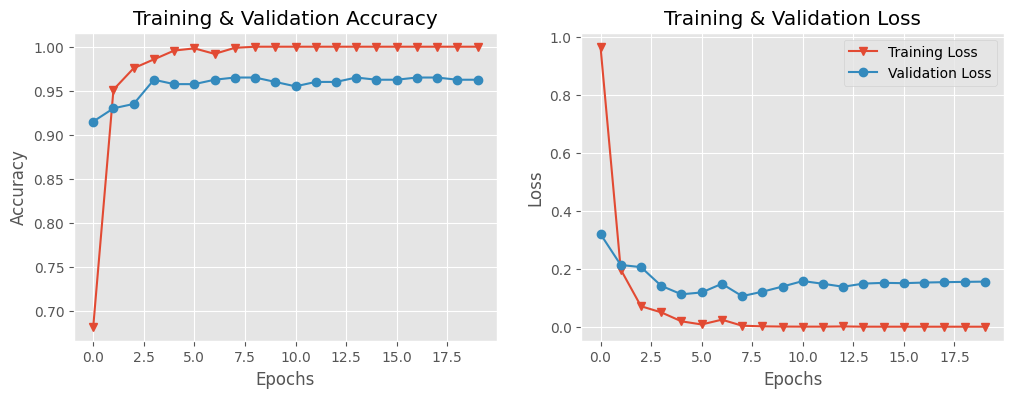

In [ ]:
# Create a figure with a specific size (12 units wide and 4 units tall).
plt.figure(figsize = (12, 4))
# Create a subplot with 1 row, 2 columns, and select the 1st subplot.
plt.subplot(1, 2, 1)

# Plot the training accuracy over epochs and label it as "Training Accuracy".
plt.plot(rnn_his.history["accuracy"], label = "Training Accuracy", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Accuracy".
plt.plot(rnn_his.history["val_accuracy"], label = "Validation Accuracy", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Set the title of the plot as "Training & Validation Accuracy".
plt.title("Training & Validation Accuracy")

# Select the 2nd subplot.
plt.subplot(1, 2, 2)

# Plot the training loss over epochs and label it as "Training Loss".
plt.plot(rnn_his.history["loss"], label = "Training Loss", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Loss".
plt.plot(rnn_his.history["val_loss"], label = "Validation Loss", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Set the title of the plot as "Training & Validation  Loss".
plt.title("Training & Validation Loss")

# Display a legend indicating which line represents which data.
plt.legend()

# Display the graph.
plt.show()

#### GRU

In [ ]:
# Build GRU model with batch size [64, 128].
base_rnn = BaseRNN("gru", 128, [64, 128], dm) 
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_his = base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 11s 243ms/step - loss: 1.6839 - accuracy: 0.2562 - val_loss: 1.6113 - val_accuracy: 0.3150
Epoch 2/20
25/25 [==============================] - 4s 173ms/step - loss: 1.3857 - accuracy: 0.4081 - val_loss: 0.9495 - val_accuracy: 0.5725
Epoch 3/20
25/25 [==============================] - 9s 352ms/step - loss: 0.7497 - accuracy: 0.7188 - val_loss: 0.5076 - val_accuracy: 0.8275
Epoch 4/20
25/25 [==============================] - 8s 316ms/step - loss: 0.2736 - accuracy: 0.9281 - val_loss: 0.2659 - val_accuracy: 0.9300
Epoch 5/20
25/25 [==============================] - 4s 174ms/step - loss: 0.0989 - accuracy: 0.9719 - val_loss: 0.2200 - val_accuracy: 0.9425
Epoch 6/20
25/25 [==============================] - 8s 337ms/step - loss: 0.0601 - accuracy: 0.9837 - val_loss: 0.1550 - val_accuracy: 0.9600
Epoch 7/20
25/25 [==============================] - 12s 470ms/step - loss: 0.0277 - accuracy: 0.9912 - val_loss: 0.1385 - val_accuracy: 0.9650
Epoc

In [ ]:
# Evaluate the model.
base_rnn.evaluate(dm.tf_valid_set.batch(64))

7/7 [==============================] - 0s 51ms/step - loss: 0.1895 - accuracy: 0.9700


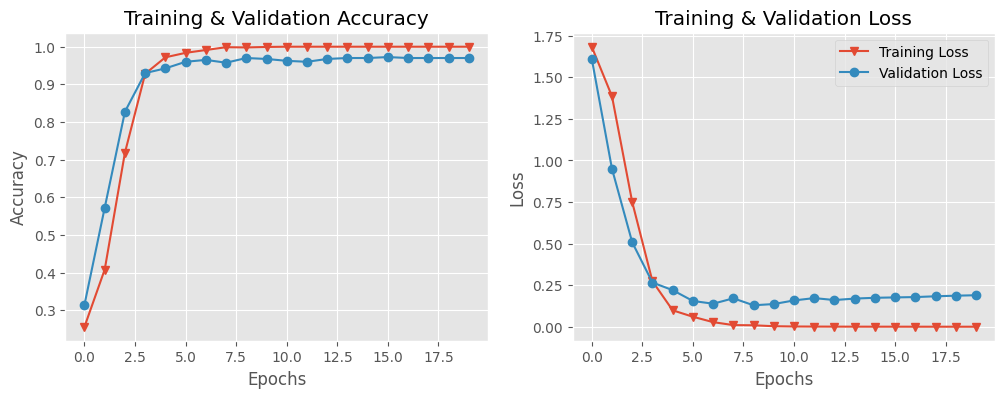

In [ ]:
# Create a figure with a specific size (12 units wide and 4 units tall).
plt.figure(figsize = (12, 4))
# Create a subplot with 1 row, 2 columns, and select the 1st subplot.
plt.subplot(1, 2, 1)

# Plot the training accuracy over epochs and label it as "Training Accuracy".
plt.plot(gru_his.history["accuracy"], label = "Training Accuracy", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Accuracy".
plt.plot(gru_his.history["val_accuracy"], label = "Validation Accuracy", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Set the title of the plot as "Training & Validation Accuracy".
plt.title("Training & Validation Accuracy")

# Select the 2nd subplot.
plt.subplot(1, 2, 2)

# Plot the training loss over epochs and label it as "Training Loss".
plt.plot(gru_his.history["loss"], label = "Training Loss", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Loss".
plt.plot(gru_his.history["val_loss"], label = "Validation Loss", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Set the title of the plot as "Training & Validation  Loss".
plt.title("Training & Validation Loss")

# Display a legend indicating which line represents which data.
plt.legend()

# Display the graph.
plt.show()

#### LSTM

In [ ]:
# Build LSTM model with batch size [64, 128].
base_rnn = BaseRNN("lstm", 128, [64, 128], dm) 
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_his = base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 19s 257ms/step - loss: 1.6672 - accuracy: 0.2837 - val_loss: 1.4591 - val_accuracy: 0.3425
Epoch 2/20
25/25 [==============================] - 6s 258ms/step - loss: 0.9649 - accuracy: 0.6794 - val_loss: 0.6164 - val_accuracy: 0.8550
Epoch 3/20
25/25 [==============================] - 11s 441ms/step - loss: 0.3560 - accuracy: 0.9156 - val_loss: 0.2306 - val_accuracy: 0.9300
Epoch 4/20
25/25 [==============================] - 5s 200ms/step - loss: 0.1309 - accuracy: 0.9675 - val_loss: 0.1842 - val_accuracy: 0.9350
Epoch 5/20
25/25 [==============================] - 5s 202ms/step - loss: 0.0697 - accuracy: 0.9831 - val_loss: 0.1166 - val_accuracy: 0.9500
Epoch 6/20
25/25 [==============================] - 5s 202ms/step - loss: 0.0443 - accuracy: 0.9856 - val_loss: 0.0924 - val_accuracy: 0.9575
Epoch 7/20
25/25 [==============================] - 12s 480ms/step - loss: 0.0260 - accuracy: 0.9919 - val_loss: 0.0903 - val_accuracy: 0.9675
Epo

In [ ]:
# Evaluate the model.
base_rnn.evaluate(dm.tf_valid_set.batch(64))

7/7 [==============================] - 0s 58ms/step - loss: 0.1726 - accuracy: 0.9650


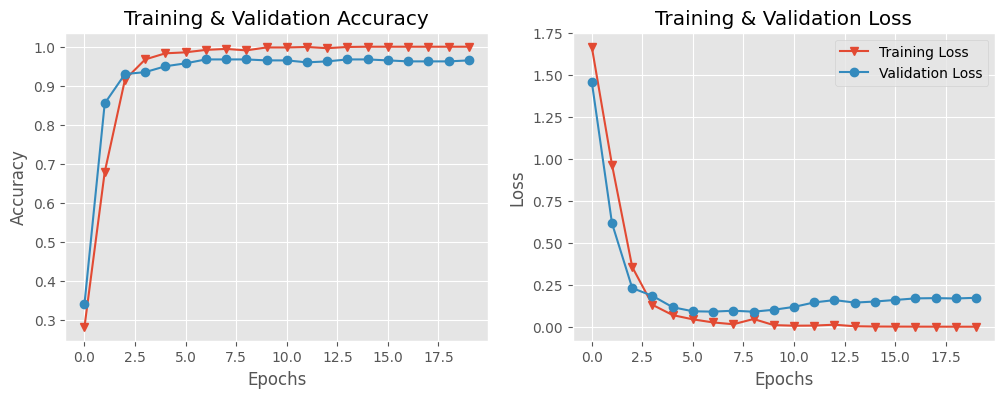

In [ ]:
# Create a figure with a specific size (12 units wide and 4 units tall).
plt.figure(figsize = (12, 4))
# Create a subplot with 1 row, 2 columns, and select the 1st subplot.
plt.subplot(1, 2, 1)

# Plot the training accuracy over epochs and label it as "Training Accuracy".
plt.plot(lstm_his.history["accuracy"], label = "Training Accuracy", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Accuracy".
plt.plot(lstm_his.history["val_accuracy"], label = "Validation Accuracy", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Set the title of the plot as "Training & Validation Accuracy".
plt.title("Training & Validation Accuracy")

# Select the 2nd subplot.
plt.subplot(1, 2, 2)

# Plot the training loss over epochs and label it as "Training Loss".
plt.plot(lstm_his.history["loss"], label = "Training Loss", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Loss".
plt.plot(lstm_his.history["val_loss"], label = "Validation Loss", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Set the title of the plot as "Training & Validation  Loss".
plt.title("Training & Validation Loss")

# Display a legend indicating which line represents which data.
plt.legend()

# Display the graph.
plt.show()

\# Give your comments on the results here (maximum 150 words)
<br>
<br>
For both state sizes [32, 64] and [64, 128], GRU performed slightly better with an accuracy of 95.8% and 97% respectively. This could be because GRUs have gating units similar to LSTMs, with the exception of a memory unit, making them more efficient at capturing long-term dependencies compared to simple RNNs. Furthermore, increasing the state size from [32, 64] to [64, 128] resulted in improved accuracy for all three cell types. Simple RNN accuracy went from 95% to 96.3% whereas LTSM improved from 94.8% to 96.5%. This suggests that a larger state size allows the model to capture more complex patterns in the data, leading to better performance.
<br>
<br>
(108 words)

### <span style="color:#0b486b">3.2. RNNs with fine-tuning embedding matrix</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 8 marks]<span></div>

#### <span style="color:red">**Question 3.2.1**</span> 

**In what follows, you are required to extend the class BaseRNN in Part 3.1 to achieve a class RNN in which the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either 'init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><span style="color:red">[6 marks]</span></div>

In [ ]:
class RNN(BaseRNN):
    def __init__(self, run_mode='scratch', embed_model='glove-wiki-gigaword-100', **kwargs):
        super().__init__(**kwargs)
        self.run_mode = run_mode
        self.embed_model = embed_model
        if self.run_mode != 'scratch':
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape=[self.vocab_size, self.embed_size])

    def build_embedding_matrix(self):
        if self.run_mode != "scratch":
            # Load a pre-trained word embedding model using the specified model file.
            self.word2vect = api.load(self.embed_model)

            # Convert the dictionary of word indices to a list of (word, index) pairs.
            items = list(self.word2idx.items())

            # Loop through the (word, index) pairs in the list.
            i = 0
            while i < len(items):
                word, index = items[i]    # Get the word and index from the pairs.
                
                # Check if the word is present in the pre-trained word embedding model.
                if word in self.word2vect:
                    # If the word is in the model, assign its vector to the corresponding row in the embedding matrix.
                    self.embed_matrix[index] = self.word2vect[word]
                
                i += 1      # Increment i by one.
                                  
    def build(self):
        # Define an input layer with variable sequence length. None by default.
        x = tf.keras.layers.Input(shape=[None])

        # Check the run mode to determine whether to use pre-trained embeddings.
        # # Use pre-trained word embeddings if not in "scratch" mode.
        if self.run_mode != "scratch":
            trainable = self.run_mode == "init-fine-tune"
            
            # Initialise the embedding layer with the provided embedding matrix and set it as non-trainable or trainable.
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, tf.keras.initializers.Constant(self.embed_matrix), mask_zero = True, trainable = trainable)(x)
        # Else if in "scratch" mode.
        else:
            h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True)(x)

        # Loop through the list of state sizes.
        i = 0
        while i < len(self.state_sizes):
            return_sequence = i != (len(self.state_sizes) - 1)
            
            # Apply a recurrent layer with the specified state size and return sequence configuration.
            h = self.get_layer(self.cell_type, self.state_sizes[i], return_sequence)(h)
            
            i += 1

        # Add a dense layer with dm.num_classes units and softmax activation for classification.
        h = tf.keras.layers.Dense(dm.num_classes, "softmax")(h)

        # Create the final model by specifying input and output layers.
        self.model = tf.keras.Model(x, h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)

#### <span style="color:red">**Question 3.2.2**</span> 

**Write code to conduct experiments to compare three running modes for the embedding matrix. Note that you should stick with fixed values for other attributes and only vary *run_mode*. Give your comments on the results.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

### Scratch

In [ ]:
# Build Scrach RNN model with batch size [64, 128]. Gru cell type as it performed the best.
base_rnn = RNN("scratch", cell_type = "gru", embed_size = 128, state_sizes = [64, 128], data_manager = dm)
base_rnn.build_embedding_matrix()
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
scratch_his = base_rnn.fit(dm.tf_train_set.batch(64), epochs = 20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 14s 283ms/step - loss: 1.6741 - accuracy: 0.2600 - val_loss: 1.6013 - val_accuracy: 0.2550
Epoch 2/20
25/25 [==============================] - 5s 197ms/step - loss: 1.2494 - accuracy: 0.4900 - val_loss: 0.7838 - val_accuracy: 0.6975
Epoch 3/20
25/25 [==============================] - 5s 221ms/step - loss: 0.5309 - accuracy: 0.8331 - val_loss: 0.3741 - val_accuracy: 0.9025
Epoch 4/20
25/25 [==============================] - 5s 192ms/step - loss: 0.2003 - accuracy: 0.9469 - val_loss: 0.2473 - val_accuracy: 0.9100
Epoch 5/20
25/25 [==============================] - 5s 190ms/step - loss: 0.0933 - accuracy: 0.9706 - val_loss: 0.2671 - val_accuracy: 0.9100
Epoch 6/20
25/25 [==============================] - 5s 204ms/step - loss: 0.0607 - accuracy: 0.9869 - val_loss: 0.2605 - val_accuracy: 0.9350
Epoch 7/20
25/25 [==============================] - 5s 186ms/step - loss: 0.0234 - accuracy: 0.9950 - val_loss: 0.2372 - val_accuracy: 0.9400
Epoch

In [ ]:
# Evaluate the model.
base_rnn.evaluate(dm.tf_valid_set.batch(64))

7/7 [==============================] - 0s 54ms/step - loss: 0.2921 - accuracy: 0.9525


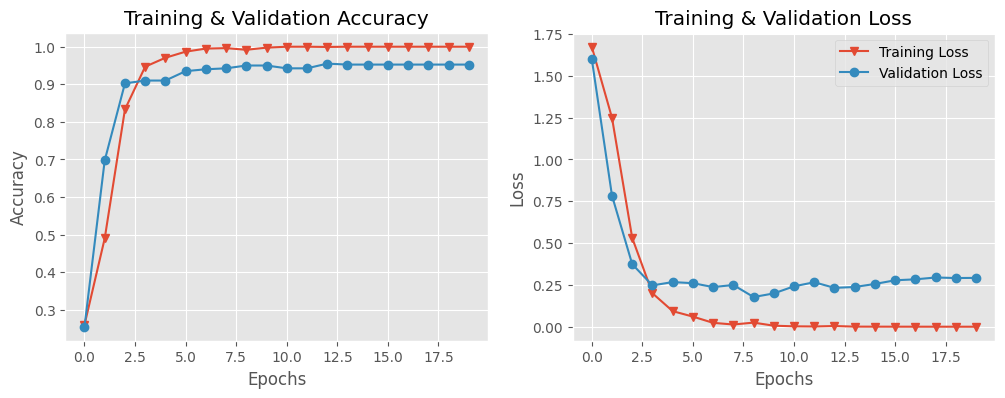

In [ ]:
# Create a figure with a specific size (12 units wide and 4 units tall).
plt.figure(figsize = (12, 4))
# Create a subplot with 1 row, 2 columns, and select the 1st subplot.
plt.subplot(1, 2, 1)

# Plot the training accuracy over epochs and label it as "Training Accuracy".
plt.plot(scratch_his.history["accuracy"], label = "Training Accuracy", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Accuracy".
plt.plot(scratch_his.history["val_accuracy"], label = "Validation Accuracy", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Set the title of the plot as "Training & Validation Accuracy".
plt.title("Training & Validation Accuracy")

# Select the 2nd subplot.
plt.subplot(1, 2, 2)

# Plot the training loss over epochs and label it as "Training Loss".
plt.plot(scratch_his.history["loss"], label = "Training Loss", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Loss".
plt.plot(scratch_his.history["val_loss"], label = "Validation Loss", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Set the title of the plot as "Training & Validation  Loss".
plt.title("Training & Validation Loss")

# Display a legend indicating which line represents which data.
plt.legend()

# Display the graph.
plt.show()

### Init-Only

In [ ]:
# Build INIT-ONLY RNN model with batch size [64, 128]. Gru cell type as it performed the best.
base_rnn = RNN("init-only", cell_type = "gru", embed_size = 128, state_sizes = [64, 128], data_manager = dm)
base_rnn.build_embedding_matrix()
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
init_his = base_rnn.fit(dm.tf_train_set.batch(64), epochs = 20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 11s 260ms/step - loss: 1.4886 - accuracy: 0.4000 - val_loss: 1.1416 - val_accuracy: 0.5900
Epoch 2/20
25/25 [==============================] - 5s 198ms/step - loss: 0.8628 - accuracy: 0.6988 - val_loss: 0.5350 - val_accuracy: 0.8075
Epoch 3/20
25/25 [==============================] - 4s 170ms/step - loss: 0.4340 - accuracy: 0.8600 - val_loss: 0.2659 - val_accuracy: 0.9225
Epoch 4/20
25/25 [==============================] - 11s 469ms/step - loss: 0.2323 - accuracy: 0.9319 - val_loss: 0.1643 - val_accuracy: 0.9450
Epoch 5/20
25/25 [==============================] - 6s 248ms/step - loss: 0.1473 - accuracy: 0.9606 - val_loss: 0.1250 - val_accuracy: 0.9600
Epoch 6/20
25/25 [==============================] - 5s 191ms/step - loss: 0.1284 - accuracy: 0.9569 - val_loss: 0.1129 - val_accuracy: 0.9575
Epoch 7/20
25/25 [==============================] - 5s 190ms/step - loss: 0.0852 - accuracy: 0.9737 - val_loss: 0.1672 - val_accuracy: 0.9450
Epoc

In [ ]:
# Evaluate the model.
base_rnn.evaluate(dm.tf_valid_set.batch(64))

7/7 [==============================] - 0s 59ms/step - loss: 0.1065 - accuracy: 0.9675


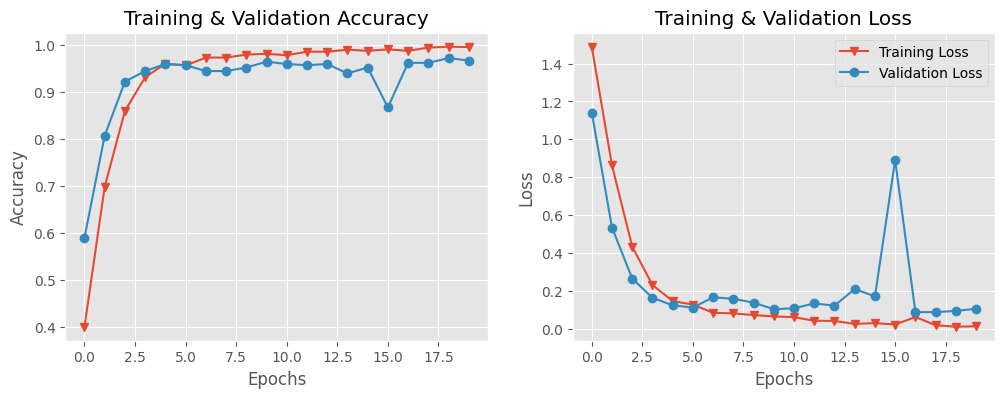

In [ ]:
# Create a figure with a specific size (12 units wide and 4 units tall).
plt.figure(figsize = (12, 4))
# Create a subplot with 1 row, 2 columns, and select the 1st subplot.
plt.subplot(1, 2, 1)

# Plot the training accuracy over epochs and label it as "Training Accuracy".
plt.plot(init_his.history["accuracy"], label = "Training Accuracy", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Accuracy".
plt.plot(init_his.history["val_accuracy"], label = "Validation Accuracy", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Set the title of the plot as "Training & Validation Accuracy".
plt.title("Training & Validation Accuracy")

# Select the 2nd subplot.
plt.subplot(1, 2, 2)

# Plot the training loss over epochs and label it as "Training Loss".
plt.plot(init_his.history["loss"], label = "Training Loss", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Loss".
plt.plot(init_his.history["val_loss"], label = "Validation Loss", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Set the title of the plot as "Training & Validation  Loss".
plt.title("Training & Validation Loss")

# Display a legend indicating which line represents which data.
plt.legend()

# Display the graph.
plt.show()

### Init-Finetune

In [ ]:
# Build INIT-FINETUNE RNN model with batch size [64, 128]. Gru cell type as it performed the best.
base_rnn = RNN("init-fine-tune", cell_type = "gru", embed_size = 128, state_sizes = [64, 128], data_manager = dm)
base_rnn.build_embedding_matrix()
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
finetune_his = base_rnn.fit(dm.tf_train_set.batch(64), epochs = 20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 9s 225ms/step - loss: 1.4997 - accuracy: 0.3919 - val_loss: 1.1758 - val_accuracy: 0.5700
Epoch 2/20
25/25 [==============================] - 4s 173ms/step - loss: 0.8460 - accuracy: 0.7056 - val_loss: 0.4981 - val_accuracy: 0.8600
Epoch 3/20
25/25 [==============================] - 4s 177ms/step - loss: 0.3663 - accuracy: 0.8894 - val_loss: 0.2175 - val_accuracy: 0.9300
Epoch 4/20
25/25 [==============================] - 4s 176ms/step - loss: 0.1855 - accuracy: 0.9419 - val_loss: 0.1724 - val_accuracy: 0.9425
Epoch 5/20
25/25 [==============================] - 4s 177ms/step - loss: 0.1225 - accuracy: 0.9606 - val_loss: 0.1942 - val_accuracy: 0.9400
Epoch 6/20
25/25 [==============================] - 5s 186ms/step - loss: 0.0807 - accuracy: 0.9737 - val_loss: 0.2867 - val_accuracy: 0.8975
Epoch 7/20
25/25 [==============================] - 9s 387ms/step - loss: 0.0662 - accuracy: 0.9775 - val_loss: 0.1609 - val_accuracy: 0.9400
Epoch 

In [ ]:
# Evaluate the model.
base_rnn.evaluate(dm.tf_valid_set.batch(64))

7/7 [==============================] - 0s 57ms/step - loss: 0.0901 - accuracy: 0.9750


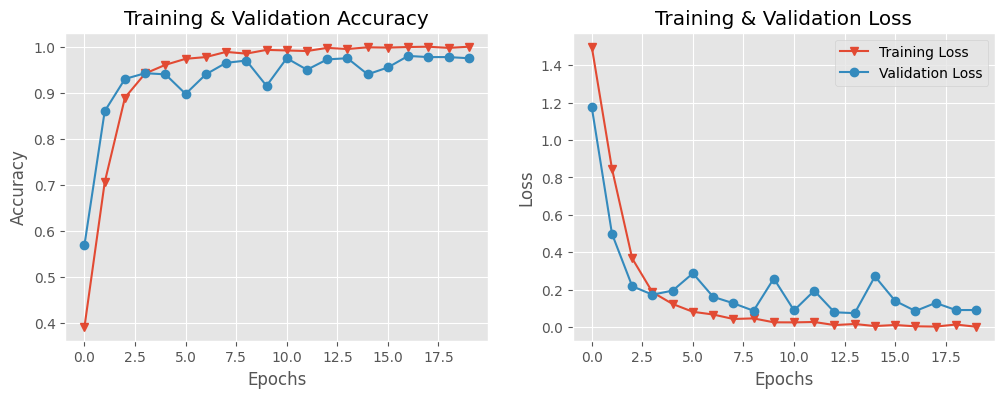

In [ ]:
# Create a figure with a specific size (12 units wide and 4 units tall).
plt.figure(figsize = (12, 4))
# Create a subplot with 1 row, 2 columns, and select the 1st subplot.
plt.subplot(1, 2, 1)

# Plot the training accuracy over epochs and label it as "Training Accuracy".
plt.plot(finetune_his.history["accuracy"], label = "Training Accuracy", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Accuracy".
plt.plot(finetune_his.history["val_accuracy"], label = "Validation Accuracy", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Set the title of the plot as "Training & Validation Accuracy".
plt.title("Training & Validation Accuracy")

# Select the 2nd subplot.
plt.subplot(1, 2, 2)

# Plot the training loss over epochs and label it as "Training Loss".
plt.plot(finetune_his.history["loss"], label = "Training Loss", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Loss".
plt.plot(finetune_his.history["val_loss"], label = "Validation Loss", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Set the title of the plot as "Training & Validation  Loss".
plt.title("Training & Validation Loss")

# Display a legend indicating which line represents which data.
plt.legend()

# Display the graph.
plt.show()

\# Give your comments on the results here (maximum 150 words)
<br>
<br>
The results indicate that the init-fine-tune model yields the highest accuracy (97.5%) and the lowest loss (9.01%). This suggests that leveraging prior knowledge from the pre-trained model and further adapting it to the specific task can lead to better performance. The init-only method also outperforms the scratch method, with an accuracy of 96.8% compared to the scratch model, as it initialises the pre-trained embedding matrix, resulting in the re-usage of prior knowledge, improving its accuracy. However, it doesn't refine the embeddings which the finetune does, thus lowering its accuracy. The scratch model has the lowest accuracy (95.3%) as it trains the embedding matrix from scratch.
<br>
<br>
(105 words)

### <span style="color:#0b486b">3.3. RNNs with Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention mechanism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $\textbf{h}_1^L, \textbf{h}_2^L,...,\textbf{h}_{T-1}^L, \textbf{h}_T^L$ be the hidden states at the last hidden layer $L$ where $T$ is the sequence length. We compute the context vector $\textbf{c}$ as $\textbf{c}=\sum_{i=1}^{T}\textbf{a}_{i}\textbf{h}_{i}^L$ where $\textbf{a}_1,...,\textbf{a}_T$ are the alignment weights (i.e., $\textbf{a}_i\geq 0$ and $\sum_{i=1}^{T}\textbf{a}_{i}=1$).**

**The alignment weights are computed as follows:**
- $\textbf{a}=[\textbf{a}_{i}]_{i=1}^{T}=\text{softmax}(\textbf{s})$ where $\textbf{s}= [\textbf{s}_{i}]_{i=1}^{T}$ consists of the alignment scores.
- The alignment scores are computed as $\textbf{s}=\text{tanh}(\textbf{h}^LU)V$ where $\textbf{h}^L=\left[\begin{array}{c}
\textbf{h}_{1}^L\\
\textbf{h}_{2}^L\\
...\\
\textbf{h}_{T-1}^L\\
\textbf{h}_{T}^L
\end{array}\right]\in\mathbb{R}^{T\times state\_size_{L}}$, $U\in\mathbb{R}^{state\_size_{L}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyperparameter. Note that if we consider a mini-batch, the shape of $\textbf{h}^L$ is $(batch\_size, T, state\_size_L)$ where $state\_size_L$ is the hidden size of the last hidden layer. The figure on the right below illustrates the process of calculating a score $\textbf{s}_i$ for an individual hidden state $\textbf{h}_i^L$. Weight matrices $U$ and $V$ are shared across the hidden states $\textbf{h}_1^L,\textbf{h}_2^L,\dots,\textbf{h}_T^L$.

**After having the context vector $\textbf{c}$, we concatenate with the last hidden state $\textbf{h}_T^L$. On top of this concatenation, we conduct the output layer with the softmax activation.**

<img src="./images/attentionRNN.png" align="center" width=700/>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 12 marks]<span></div>

#### <span style="color:red">**Question 3.3.1**</span>

**We declare the  layer `MyAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><span style="color:red">[4 marks]</span></div>

In [ ]:
class MyAttention(tf.keras.layers.Layer):
    def __init__(self, output_length=50):
        super().__init__()
        # Set the output length of the attention layer.
        self.output_length = output_length
        
    def build(self, input_shape):
        # Define the shape of the weight matrices U and V.
        u_shape = (input_shape[-1], self.output_length)
        v_shape = (self.output_length, 1)
        
        # Add weight matrices U and V to the layer. These weight matrices will be learned during training.
        self.U = self.add_weight(shape = u_shape, initializer = "random_normal", trainable = True)
        self.V = self.add_weight(shape = v_shape, initializer = "random_normal", trainable = True)
    
    # all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        # Compute the similarity scores between all_states and the learned weight matrix U.
        s = tf.tanh(tf.tensordot(all_states, self.U, axes=1))
        # Compute the context vector as a weighted sum using the learned weight matrix V.
        c = tf.tensordot(s, self.V, axes=1)
        # Apply the softmax function along the axis 1 to get attention weights.
        a = tf.nn.softmax(c, axis=1)
        # Compute the context vector by taking the weighted sum of all_states.
        c = tf.reduce_sum(a * all_states, axis=1)
        # Concatenate the context vector and the last state vector.
        h = tf.concat([c, last_state], axis=-1)

        return h    # Return the hidden state.

#### <span style="color:red">**Question 3.3.2**</span> 

**You are required to extend the class `RNN` in Question `3.2.1` to achieve the class `AttentionRNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[6 marks]</span></div>

In [ ]:
class AttentionRNN(RNN):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    @staticmethod
    def get_layer(cell_type='gru', hidden_size=128, return_sequences=False, activation='tanh'):
        if cell_type == "simple-rnn":
            return tf.keras.layers.SimpleRNN(hidden_size, activation, return_sequences = return_sequences)
        elif cell_type == "gru":
            return tf.keras.layers.GRU(hidden_size, activation, return_sequences = return_sequences)
        elif cell_type == "lstm":
            return tf.keras.layers.LSTM(hidden_size, activation, return_sequences = return_sequences)

    def build(self):
        # Define an input layer with variable sequence length. None by default.
        x = tf.keras.layers.Input(shape = [None])
        # Create an embedding layer with self.vocab_size vocabulary size and self.embed_size embedding dimensions.
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True)(x)

        # Iterate through the list of state sizes.
        i = 0
        while i < (len(self.state_sizes) - 1):
            # Apply a recurrent layer with the specified state size and return sequence configuration.
            h =  self.get_layer(self.cell_type, self.state_sizes[i], return_sequences = True)(h)
            
            i += 1      # Increment the i loop control variable.
        
        # Apply another recurrent layer with the state size specified for the last state.
        all_states = self.get_layer(self.cell_type, self.state_sizes[-1], return_sequences = True)(h)
        # Extract the last state from 'all_states' (last time step of the sequence).
        last_state = all_states[:, -1, :]
        # Apply a custom attention layer using the MyAttention class.
        h = MyAttention()(all_states, last_state)
        # Add a dense layer with dm.num_classes units and softmax activation for classification.
        h = tf.keras.layers.Dense(dm.num_classes, "softmax")(h)
        # Create the final model by specifying input and output layers.
        self.model = tf.keras.Model(x, h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 3.3.3**</span> 

**Choose a common setting for standard RNN and RNN with attention and conduct experiments to compare them. The setting here means `run_mode`, `cell_type` and list of `state_sizes`. Give your comments on the results.** 

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

### Standard RNN

In [ ]:
# Build Standard RNN model with batch size [64, 128]. Gru cell type as it performed the best.
base_rnn = RNN("init-fine-tune", cell_type = "gru", embed_size = 128, state_sizes = [64, 128], data_manager = dm)
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
standard_rnn_his = base_rnn.fit(dm.tf_train_set.batch(64), epochs = 20, validation_data = dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 21s 631ms/step - loss: 1.6847 - accuracy: 0.2362 - val_loss: 1.6239 - val_accuracy: 0.2375
Epoch 2/20
25/25 [==============================] - 7s 285ms/step - loss: 1.4298 - accuracy: 0.3869 - val_loss: 1.0440 - val_accuracy: 0.5325
Epoch 3/20
25/25 [==============================] - 7s 282ms/step - loss: 0.6988 - accuracy: 0.7206 - val_loss: 0.4279 - val_accuracy: 0.8775
Epoch 4/20
25/25 [==============================] - 7s 277ms/step - loss: 0.2722 - accuracy: 0.9244 - val_loss: 0.2045 - val_accuracy: 0.9225
Epoch 5/20
25/25 [==============================] - 7s 275ms/step - loss: 0.1016 - accuracy: 0.9712 - val_loss: 0.1606 - val_accuracy: 0.9525
Epoch 6/20
25/25 [==============================] - 7s 275ms/step - loss: 0.0489 - accuracy: 0.9869 - val_loss: 0.2455 - val_accuracy: 0.9275
Epoch 7/20
25/25 [==============================] - 7s 274ms/step - loss: 0.0289 - accuracy: 0.9912 - val_loss: 0.1288 - val_accuracy: 0.9575
Epoch

In [ ]:
# Evaluate the model.
base_rnn.evaluate(dm.tf_valid_set.batch(64))

7/7 [==============================] - 1s 74ms/step - loss: 0.2047 - accuracy: 0.9550


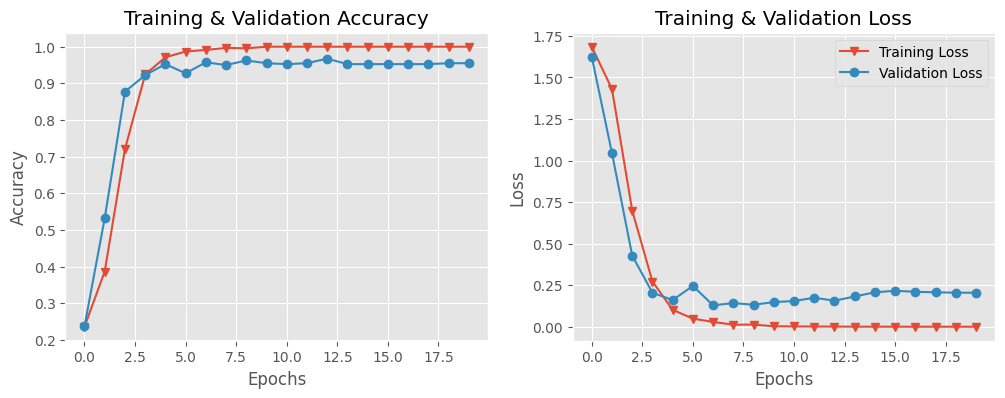

In [ ]:
# Create a figure with a specific size (12 units wide and 4 units tall).
plt.figure(figsize = (12, 4))
# Create a subplot with 1 row, 2 columns, and select the 1st subplot.
plt.subplot(1, 2, 1)

# Plot the training accuracy over epochs and label it as "Training Accuracy".
plt.plot(standard_rnn_his.history["accuracy"], label = "Training Accuracy", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Accuracy".
plt.plot(standard_rnn_his.history["val_accuracy"], label = "Validation Accuracy", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Set the title of the plot as "Training & Validation Accuracy".
plt.title("Training & Validation Accuracy")

# Select the 2nd subplot.
plt.subplot(1, 2, 2)

# Plot the training loss over epochs and label it as "Training Loss".
plt.plot(standard_rnn_his.history["loss"], label = "Training Loss", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Loss".
plt.plot(standard_rnn_his.history["val_loss"], label = "Validation Loss", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Set the title of the plot as "Training & Validation  Loss".
plt.title("Training & Validation Loss")

# Display a legend indicating which line represents which data.
plt.legend()

# Display the graph.
plt.show()

### Attention RNN

In [ ]:
# Build Standard RNN model with batch size [64, 128]. Gru cell type as it performed the best.
base_rnn = AttentionRNN(run_mode = "init-fine-tune", cell_type = "gru", state_sizes = [64, 128], data_manager = dm)
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
attention_rnn_his = base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 14s 380ms/step - loss: 1.6771 - accuracy: 0.2606 - val_loss: 1.6133 - val_accuracy: 0.2300
Epoch 2/20
25/25 [==============================] - 6s 254ms/step - loss: 1.3335 - accuracy: 0.4431 - val_loss: 0.9171 - val_accuracy: 0.6050
Epoch 3/20
25/25 [==============================] - 6s 252ms/step - loss: 0.6337 - accuracy: 0.7675 - val_loss: 0.4816 - val_accuracy: 0.8400
Epoch 4/20
25/25 [==============================] - 6s 252ms/step - loss: 0.2590 - accuracy: 0.9306 - val_loss: 0.2644 - val_accuracy: 0.9150
Epoch 5/20
25/25 [==============================] - 6s 251ms/step - loss: 0.0752 - accuracy: 0.9819 - val_loss: 0.1741 - val_accuracy: 0.9425
Epoch 6/20
25/25 [==============================] - 6s 252ms/step - loss: 0.0463 - accuracy: 0.9906 - val_loss: 0.3541 - val_accuracy: 0.9100
Epoch 7/20
25/25 [==============================] - 6s 252ms/step - loss: 0.0285 - accuracy: 0.9919 - val_loss: 0.1383 - val_accuracy: 0.9625
Epoch

In [ ]:
# Evaluate the model.
base_rnn.evaluate(dm.tf_valid_set.batch(64))

7/7 [==============================] - 1s 89ms/step - loss: 0.1894 - accuracy: 0.9650


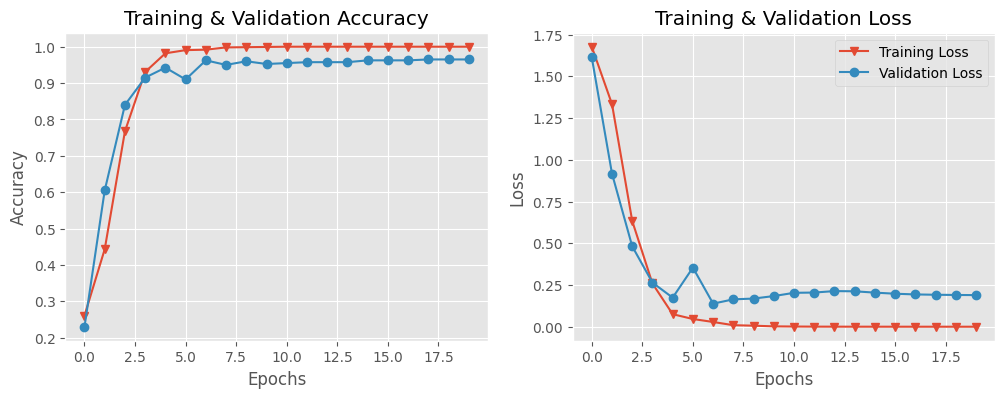

In [ ]:
# Create a figure with a specific size (12 units wide and 4 units tall).
plt.figure(figsize = (12, 4))
# Create a subplot with 1 row, 2 columns, and select the 1st subplot.
plt.subplot(1, 2, 1)

# Plot the training accuracy over epochs and label it as "Training Accuracy".
plt.plot(attention_rnn_his.history["accuracy"], label = "Training Accuracy", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Accuracy".
plt.plot(attention_rnn_his.history["val_accuracy"], label = "Validation Accuracy", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Set the title of the plot as "Training & Validation Accuracy".
plt.title("Training & Validation Accuracy")

# Select the 2nd subplot.
plt.subplot(1, 2, 2)

# Plot the training loss over epochs and label it as "Training Loss".
plt.plot(attention_rnn_his.history["loss"], label = "Training Loss", marker='v')
# Plot the validation accuracy over epochs and label it as "Validation Loss".
plt.plot(attention_rnn_his.history["val_loss"], label = "Validation Loss", marker='o')

# Label the x-axis and y-axis.
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Set the title of the plot as "Training & Validation  Loss".
plt.title("Training & Validation Loss")

# Display a legend indicating which line represents which data.
plt.legend()

# Display the graph.
plt.show()

\# Give your comments on the results here (maximum 150 words)
<br>
<br>
The parameters that produced the best results from previous experiments, (run_mode = "init-fine-tune", cell_type = "gru", state_sizes = [64, 128]). The Standard RNN model achieved an accuracy of 95.5% whereas the Attention RNN achieved a higher accuracy of 96.5%. This is because the Standard RNN model faced the vanishing gradient problem, resulting in a lower accuracy rate. The attention mechanism enables the RNN model to focus on various segments of the input sequence, allowing all the hidden states to be weighed according to its attention score. Through this, it enables the model to more effectively capture long-term dependencies compared to the standard version, leading to a higher overall accuracy rate.
<br>
<br>
(110 words)

## <span style="color:#0b486b">Part 4: Transformer-based models for sequence modeling and neural embedding and the overall ranking</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 23 marks]<span></div>

#### <span style="color:red">**Question 4.1**</span> 

**Implement the multi-head attention module of the Transformer for the text classification problem. The provided code is from [this source](https://keras.io/examples/nlp/text_classification_with_transformer/). In this part, we only use the output of the Transformer encoder for the classification task. For further information on the Transformer model, refer to [this paper](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).**

<div style="text-align: right"><span style="color:red">[11 marks]</span></div>

In [22]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        # Initialise the MultiHeadAttention layer.
        self.embed_dim = embed_dim      # Set the embedding dimension instance variables.
        self.num_heads = num_heads      # Set the number of attention heads instance variables.

        # Ensure that the embedding dimension is divisible by the number of heads. Returns error if not.
        assert embed_dim % self.num_heads == 0

        # Calculate the dimension of each head's projection and set it to projection_dim instance variable.
        self.projection_dim = embed_dim // num_heads

        # Define linear transformations for queries, keys, values, and output combination.
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        # Calculate scaled dot-product attention scores.
        scaled_score = (tf.matmul(query, key, transpose_b=True)) / (tf.math.sqrt(tf.cast(tf.shape(key)[-1], tf.float32)))
        weights = tf.nn.softmax(scaled_score, axis = -1)
        
        # Compute the weighted sum of values and return both the output and attention weights.
        output = tf.matmul(weights, value)
        return output, weights      # Return the output tensor and weights.

    def separate_heads(self, x, batch_size):
        # Reshape the input tensor to facilitate multi-head processing.
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        
        # Transpose the dimensions for proper multi-head computation.
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # Get the batch size from the input.
        batch_size = tf.shape(inputs)[0]

        # Project the inputs into query, key, and value tensors for each head.
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # Separate the heads for query, key, and value tensors.
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        # Calculate multi-head attention and obtain attention weights.
        attention, weights = self.attention(query, key, value)

        # Transpose the attention tensor for combining heads.
        attention = tf.transpose(attention, perm = [0, 2, 1, 3])

        # Reshape and project the concatenated attention back to the original dimension.
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)

        # Return the output tensor.
        return output

In [24]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(embed_dim = embed_dim, num_heads = num_heads)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [25]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [26]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Sequential

vocab_size = dm.vocab_size + 1
maxlen = dm.maxlen

def create_tfm_model(embed_dim=64, num_heads=8, ff_dim=32, dropout_rate=0.1):
    """
    Creates a Transformer model using the given hyperparameters.

    Parameters:
        embed_dim (int): The embedding dimension for each token.
        num_heads (int): The number of attention heads in the multi-head attention layer.
        ff_dim (int): The hidden layer size in the feed forward network inside the transformer block.
        dropout_rate (float): The dropout rate for regularization.
    Returns:
        keras.models.Sequential: A Transformer model.
    """
    tfm = Sequential()
    tfm.add(Input(shape=(maxlen,)))
    tfm.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)
    tfm.add(transformer_block)
    tfm.add(GlobalAveragePooling1D())
    tfm.add(Dropout(dropout_rate))
    tfm.add(Dense(units=dm.num_classes, activation='softmax'))
    tfm.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return tfm

In [27]:
model = create_tfm_model()
model.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 4s 92ms/step - loss: 1.7222 - accuracy: 0.2313 - val_loss: 1.6367 - val_accuracy: 0.2125
Epoch 2/20
25/25 [==============================] - 2s 80ms/step - loss: 1.5799 - accuracy: 0.3344 - val_loss: 1.4903 - val_accuracy: 0.5625
Epoch 3/20
25/25 [==============================] - 2s 79ms/step - loss: 1.3772 - accuracy: 0.5250 - val_loss: 1.3664 - val_accuracy: 0.5100
Epoch 4/20
25/25 [==============================] - 2s 79ms/step - loss: 0.9447 - accuracy: 0.7606 - val_loss: 0.7726 - val_accuracy: 0.8475
Epoch 5/20
25/25 [==============================] - 2s 78ms/step - loss: 0.3247 - accuracy: 0.9475 - val_loss: 0.2791 - val_accuracy: 0.9250
Epoch 6/20
25/25 [==============================] - 2s 78ms/step - loss: 0.0870 - accuracy: 0.9856 - val_loss: 0.2346 - val_accuracy: 0.9175
Epoch 7/20
25/25 [==============================] - 2s 78ms/step - loss: 0.0461 - accuracy: 0.9887 - val_loss: 0.1314 - val_accuracy: 0.9475
Epoch 8/20
25

#### <span style="color:red">**Question 4.2**</span> 
**Write code to conduct experiments to evaluate the impact of hyperparameters `embed_dim`, `num_heads`, `ff_dim`, and `dropout_rate` of the Transformer model on the accuracy. Report (i) your findings from the experiments, (ii) the accuracy of your best Transformer model (i.e., the one with the highest accuracy on the validation set), and (iii) the values of the mentioned hyperparameters of that best model.  
Note that the necessary condition to get the full mark for this question is that the accuracy of your best Transformer model should be at least 90%.** 
<div style="text-align: right"><span style="color:red">[3 marks]</span></div>

In [32]:
# Import ParameterGrid to create a grid of all possible hyperparameters.
from sklearn.model_selection import ParameterGrid

# Define a list of hyperparameter values to explore in a grid search.
# ParameterGrid will create all possible combinations of these values.
hyperparameters_list = list(ParameterGrid({
    "embed_dim": [32, 64, 128],         # Dimension of word embeddings.
    "num_heads": [2, 4, 8],             # Number of attention heads in the model.
    "ff_dim": [32, 64, 128],            # Dimension of the feed-forward layer.
    "dropout_rate": [0.1, 0.2, 0.3]     # Dropout rate for regularisation.
}))

In [33]:
# Initialize variables to keep track of the best accuracy and corresponding hyperparameters.
best_accuracy = 0       # Initialise the best accuracy to 0 by default.
best_params = None      # Initialise the best hyperparameters to None by default.

# Loop through the list of all possible hyperparameter combinations.
for hyperparameters in hyperparameters_list:
    print(hyperparameters)      # Print the current set of hyperparameters being evaluated.
    # Create a model using the current set of hyperparameters.
    model = create_tfm_model(**hyperparameters)
    # Train the model on the training dataset and validate it on the validation dataset with 20 epochs.
    his = model.fit(dm.tf_train_set.batch(64), epochs = 20, verbose = 0, validation_data = dm.tf_valid_set.batch(64))
    
    accuracy = his.history["val_accuracy"][-1]      # Get the validation accuracy after training.
    
    # Check if the current accuracy is better than the previous best accuracy.
    if accuracy > best_accuracy:
        # If so, update the best accuracy and best hyperparameters to the current one.
        best_accuracy = accuracy
        best_params = hyperparameters
    
    # Evaluate the model's performance on the validation dataset.
    model.evaluate(dm.tf_valid_set.batch(64))
    print("\n")

# Print the best accuracy and the corresponding hyperparameters found during the search.
print("Best Accuracy: {0}".format(best_accuracy))
print("Best Hyperparameters: {0}".format(best_params))

{'dropout_rate': 0.1, 'embed_dim': 32, 'ff_dim': 32, 'num_heads': 2}
7/7 [==============================] - 0s 11ms/step - loss: 0.0931 - accuracy: 0.9725


{'dropout_rate': 0.1, 'embed_dim': 32, 'ff_dim': 32, 'num_heads': 4}
7/7 [==============================] - 0s 14ms/step - loss: 0.1150 - accuracy: 0.9675


{'dropout_rate': 0.1, 'embed_dim': 32, 'ff_dim': 32, 'num_heads': 8}
7/7 [==============================] - 0s 35ms/step - loss: 0.1382 - accuracy: 0.9600


{'dropout_rate': 0.1, 'embed_dim': 32, 'ff_dim': 64, 'num_heads': 2}
7/7 [==============================] - 0s 25ms/step - loss: 0.0875 - accuracy: 0.9750


{'dropout_rate': 0.1, 'embed_dim': 32, 'ff_dim': 64, 'num_heads': 4}
7/7 [==============================] - 0s 19ms/step - loss: 0.1132 - accuracy: 0.9650


{'dropout_rate': 0.1, 'embed_dim': 32, 'ff_dim': 64, 'num_heads': 8}
7/7 [==============================] - 0s 30ms/step - loss: 0.1406 - accuracy: 0.9575


{'dropout_rate': 0.1, 'embed_dim': 32, 'ff_dim': 128, 'num

\# Give your answer here. 

(i) Your findings from the experiments (maximum 200 words)

The hyperparameters are as follows: dropout rate (0.1, 0.2, 0.3), embedding dimensions (32, 64, 128), feed-forward dimensions (32, 64, 128) and number of heads (2, 4, 8). Every possible combination of the hyperparameters are tested and the accuracy and loss of each set are logged. 

The higher the dimensionality in the embedding, the higher the accuracy as it can capture more complex patterns in the data, resulting in better performance. Increasing the dropout rate resulted in a lower accuracy because it introduced more regularisation, causing the model to underfit the data. For the feed-forward dimension, a value of 128 performed better than 32 and 64, likely because it provided a larger capacity for the model to learn and represent the data effectively. The number of attention heads is an interesting parameter. In some cases, the smaller number of heads (2) seemed to work better than a larger number like 8, however, it's not consistent. This suggests that the optimal number of heads may depend on other specific characteristics of the dataset. 

(171 words)

(ii) The accuracy of your best Transformer model on the validation set

0.9825 is the accuracy of the best Transformer model.

(iii) The values of the mentioned hyperparameters of your best Transformer model

Best model hyperparameters: 
<br>
Dropout Rate = 0.1, 
<br>
Embedding Dimensions = 128, 
<br>
Feed-forward dimensions = 128, 
<br>
Number of heads = 4

#### <span style="color:red">**Question 4.3**</span> 
**For any models defined in the previous questions (of all parts), you are free to fine-tune hyperparameters, e.g., `optimizer`, `learning_rate`, `state_sizes`, such that you get a best model, i.e., the one with the highest accuracy on the validation set. You will need to report (i) what is your best model,  (ii) its accuracy on the validation set, and (iii) the values of its hyperparameters. Note that you must report your best model's accuracy with rounding to 4 decimal places, i.e., 0.xxxx. You will also need to upload your best model (or provide us with the link to download your best model). The assessment will be based on your best model's accuracy, with up to 9 marks available, specifically:**
* The best accuracy $\ge$ 0.98: 9 marks
* 0.98 $>$ The best accuracy $\ge$ 0.92: 6 marks
* 0.92 $>$ The best accuracy $\ge$ 0.85: 3 marks
* The best accuracy $<$ 0.85: 0 mark
<div style="text-align: right"><span style="color:red">[9 marks]</span></div>

In [41]:
# Import optimizer classes from TensorFlow/Keras for different optimisers.
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define a list of hyperparameter values to explore in a grid search.
# ParameterGrid will create all possible combinations of these values.
hyperparameters_list = list(ParameterGrid({
    "optimiser": [Adam, SGD, RMSprop],      # List of optimiser classes.
    "learning_rate": [0.0001, 0.001, 0.01]     # List of learning rates.
}))

In [42]:
# Initialize variables to keep track of the best accuracy and corresponding hyperparameters.
best_accuracy = 0       # Initialise the best accuracy to 0 by default.
best_params = None      # Initialise the best hyperparameters to None by default.
best_model = None       # Initialise the best model to None by default.

# Loop through the list of all possible hyperparameter combinations.
for hyperparameters in hyperparameters_list:
    optimiser = hyperparameters["optimiser"]
    
    print(hyperparameters)      # Print the current set of hyperparameters being evaluated.
    # Create a model using the best set of hyperparameters from question 4.2.
    model = create_tfm_model(embed_dim = 128, num_heads = 4, ff_dim = 128, dropout_rate = 0.1)
    # Compile the model using the current optimizer and learning rate.
    model.compile(optimizer = optimiser(learning_rate = hyperparameters["learning_rate"]), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    # Train the model on the training dataset and validate it on the validation dataset with 20 epochs.
    his = model.fit(dm.tf_train_set.batch(64), epochs = 20, verbose = 0, validation_data = dm.tf_valid_set.batch(64))
    
    accuracy = his.history["val_accuracy"][-1]      # Get the validation accuracy after training.
    
    # Check if the current accuracy is better than the previous best accuracy.
    if accuracy > best_accuracy:
        # If so, update the best accuracy, best hyperparameters and best model to the current one.
        best_accuracy = accuracy
        best_params = hyperparameters
        best_model = model
    
    # Evaluate the model's performance on the validation dataset.
    model.evaluate(dm.tf_valid_set.batch(64))
    print("\n")

# Print the best accuracy and the corresponding hyperparameters found during the search.
print("Best Accuracy: {0}".format(best_accuracy))
print("Best Hyperparameters: {0}".format(best_params))

{'learning_rate': 0.0001, 'optimiser': <class 'keras.src.optimizers.adam.Adam'>}
7/7 [==============================] - 0s 44ms/step - loss: 0.3025 - accuracy: 0.9275


{'learning_rate': 0.0001, 'optimiser': <class 'keras.src.optimizers.sgd.SGD'>}
7/7 [==============================] - 0s 59ms/step - loss: 1.6503 - accuracy: 0.2350


{'learning_rate': 0.0001, 'optimiser': <class 'keras.src.optimizers.rmsprop.RMSprop'>}
7/7 [==============================] - 0s 56ms/step - loss: 0.7973 - accuracy: 0.8125


{'learning_rate': 0.001, 'optimiser': <class 'keras.src.optimizers.adam.Adam'>}
7/7 [==============================] - 1s 91ms/step - loss: 0.0706 - accuracy: 0.9775


{'learning_rate': 0.001, 'optimiser': <class 'keras.src.optimizers.sgd.SGD'>}
7/7 [==============================] - 0s 60ms/step - loss: 1.6443 - accuracy: 0.2725


{'learning_rate': 0.001, 'optimiser': <class 'keras.src.optimizers.rmsprop.RMSprop'>}
7/7 [==============================] - 0s 64ms/step - loss: 0.1007 - 

In [45]:
best_model.save("models/question_4.3_best_model.keras")

\# Give your answer here. 

(i) What is your best model?

The best model used from question 4.2 with the hyperparameters:
<br>
Dropout Rate = 0.1,
<br>
Embedding Dimensions = 128, 
<br>
Feed-forward dimensions = 128, 
<br>
Number of heads = 4

(ii) The accuracy of your best model on the validation set

0.9775

(iii) The values of the hyperparameters of your best model

Best model hyperparameters: 
<br>
Learning Rate = 0.001, 
<br>
Optimiser = Adam

(iv) The link to download your best model

https://drive.google.com/file/d/1AFTYx5WBH_D-qshQVUnRLAlwUs--5ly5/view?usp=sharing

--- 
<div style="text-align: center"> <span style="color:green">GOOD LUCK WITH YOUR ASSIGNMENT 2!</span> </div>
<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>